In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [23]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

In [24]:
image_path = "/content/drive/MyDrive/imgae processing lab/"

## Get Image Size

In [27]:
# Image Size in Byte
def image_size(img):
  return os.path.getsize(img)

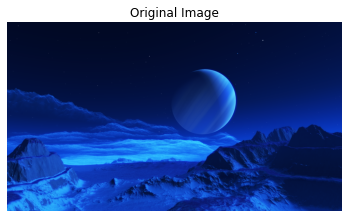

In [25]:
img = cv2.imread(f'{image_path}image.png')
show_image(img, "Original Image");

In [70]:
image_size(f'{image_path}image.png')

1344860

## Convert To GrayScale

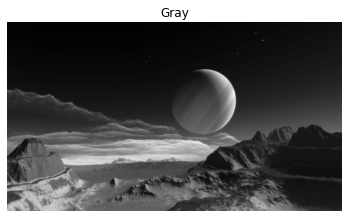

In [26]:
gray_original = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show_image(gray_original, "Gray")

In [69]:
image_size(f'{image_path}gray.png')

530656

In [28]:
gray_original.shape[0], gray_original.shape[1]

(1080, 1920)

## Calculate Bit Rate

In [29]:
def find_bit_rate(gray_image):
  cv2.imwrite(f'{image_path}gray.png', gray_image)
  gray_width, gray_height = gray_image.shape[0], gray_image.shape[1]
  gray_size = image_size(f'{image_path}gray.png')
  bit_rate = (gray_size * 8) / (gray_width * gray_height)

  return bit_rate

In [30]:
find_bit_rate(gray_original)

2.0472839506172837

## Function Calculate Entropy

In [31]:
def find_entropy(img):
  marg = np.histogramdd(np.ravel(img), bins=256)[0]/img.size
  marg = list(filter(lambda p: p > 0, np.ravel(marg)))
  entropy = -np.sum(np.multiply(marg, np.log2(marg)))
  
  return entropy

In [32]:
entropy = find_entropy(gray_original)

entropy

6.775891948997023

In [33]:
def splt2(img):
  const = 18
  [row, col] = np.shape(img)
  pred1 = np.zeros((row+1, col+1))
  pred11 = np.zeros((row+1, col+1))

  pred1[0, :] = const * np.ones((1, col+1))
  pred1[1: row+1, 0] = const
  pred1[1: row+1, 1: col+1] = img

  for i in range(1, row):
    for j in range(1, col):
      pred11[i, j] = 0.5*(pred1[i, j-1] + pred1[i-1, j])

  pred11 = pred11[1: row+1, 1:col+1]
  pred11 = img - np.fix(pred11)

  return pred11

In [34]:
compressed_img = splt2(gray_original)

In [35]:
find_entropy(compressed_img)

2.5253816987000244

In [62]:
def temporal_sptl2(img, c):
    const = 5
    case_name = '';
    [row, col] = np.shape(img)
    pred1 = np.zeros((row+1, col+1))
    pred11 = np.zeros((row+1, col+1))

    pred1[0, :] = const * np.ones((1, col+1))
    pred1[1: row+1, 0] = const
    pred1[1: row+1, 1:col+1] = img
    
    #X=B
    if c==1:
        case_name = 'X=B'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i-1][j]

    #X=C
    if c==2:
        case_name = 'X=C'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i-1][j-1]

    #X=A
    if c==3:
        case_name = 'X=A'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i][j-1]

    #X=(A+B)/2
    if c==4:
        case_name = 'X=(A+B)/2'    
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = 0.5 * (pred1[i][j-1] + pred1[i-1][j])

    #X=A+B-C
    if c==5:
        case_name = 'X=A+B-C'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i][j-1] + pred1[i-1][j] - pred1[i-1][j-1]

    #X=A+(B-C)/2            
    if c==6:
        case_name = 'X=A+(B-C)/2'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i][j-1] + (0.5 * (pred1[i-1][j] - pred1[i-1][j-1]))
                
    #X=B+(A-C)/2
    if c==7:
        case_name = 'X=B+(A-C)/2'
        for i in range(1, row):
            for j in range(1, col):
                pred11[i][j] = pred1[i-1][j] + (0.5 * (pred1[i][j-1] - pred1[i-1][j-1]))
    
    pred11 = pred11[1:row+1, 1:col+1]
    pred11 = img - np.fix(pred11)
    pred11 = pred11.astype('double')

    return {'case_name': case_name, 'value': pred11}

In [63]:
for i in range(1, 8):
  vars()[f'temp_comp_{i}'] = temporal_sptl2(gray_original, i)

In [64]:
results = []

In [65]:
for i in range(1, 8):
  vars()[f'entropy_temp_comp_{i}'] = find_entropy(vars()[f'temp_comp_{i}']['value'])

  results.append({'case_name': vars()[f'temp_comp_{i}']['case_name'], 'entropy': vars()[f'entropy_temp_comp_{i}']})

  print('Case Name: ', vars()[f'temp_comp_{i}']['case_name'], '= ', vars()[f'entropy_temp_comp_{i}'])

Case Name:  X=B =  2.7223639776822255
Case Name:  X=C =  2.8114010506429956
Case Name:  X=A =  2.127415844459623
Case Name:  X=(A+B)/2 =  2.5293280242923157
Case Name:  X=A+B-C =  2.5577683918194927
Case Name:  X=A+(B-C)/2 =  2.4427689160778967
Case Name:  X=B+(A-C)/2 =  2.6182760437154484


In [66]:
results

[{'case_name': 'X=B', 'entropy': 2.7223639776822255},
 {'case_name': 'X=C', 'entropy': 2.8114010506429956},
 {'case_name': 'X=A', 'entropy': 2.127415844459623},
 {'case_name': 'X=(A+B)/2', 'entropy': 2.5293280242923157},
 {'case_name': 'X=A+B-C', 'entropy': 2.5577683918194927},
 {'case_name': 'X=A+(B-C)/2', 'entropy': 2.4427689160778967},
 {'case_name': 'X=B+(A-C)/2', 'entropy': 2.6182760437154484}]

In [67]:
results_pd = pd.DataFrame(results)

## Entropy

In [68]:
results_pd

,case_name,entropy
0,X=B,2.722364
1,X=C,2.811401
2,X=A,2.127416
3,X=(A+B)/2,2.529328
4,X=A+B-C,2.557768
5,X=A+(B-C)/2,2.442769
6,X=B+(A-C)/2,2.618276
